In [114]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import requests as req
import emcee
import matplotlib
from matplotlib import pyplot as plt
import corner
%matplotlib inline

In [10]:
print(np.__version__)
print(pd.__version__)
print(req.__version__)
print(emcee.__version__)
print(matplotlib.__version__)
print(corner.__version__)

1.16.0
0.24.1
2.21.0
2.2.1
3.0.3
2.0.1


# Introduction

The stated purpose of this notebook is to explore some cryptocurrency data. Yahoo! doesn't seem to allow programmatic access to its financial data, including crypto data. I felt that scraping data is outside of the scope of this project and so I opted to use a [different API](https://cryptocompare.com) which provides similar data, instead.

We begin by exploring the API a little bit. We then request extensive historical price data on several cryptocurrencies. After briefly analyzing some of the summary statistics of the data, we begin to work on a predictive model of asset returns, concluding with an application to portfolio choice.

# Exploration

In [116]:
endpoint = "https://min-api.cryptocompare.com/data/"
api_key = "f42555b48bbf03e7f64fdbfde60ebe62905fd2103ec9beada0969c3d81c749a8"

In [117]:
def req_url(meth, params):
    params["api_key"] = api_key
    
    return endpoint + meth + "?" + "&".join(["{}={}".format(k, v) for k, v in params.items()])

First, we'll request the top 100 crypto symbols by volume, so that we can request the prices of them:

In [118]:
meth = "top/totalvolfull"
params = {}
params["limit"] = 100
params["tsym"] = "USD"

ru = req_url(meth, params)
data = req.get(ru).json()['Data']
top = list(map(lambda c: c['CoinInfo']['Name'], data))
n_top = len(top)

We can only request 1 crypto symbol at a time. We'll request 3 years of data:

In [121]:
meth = "histoday"

n_top = 10
raw_data = {}
for i in range(n_top):
    params = {}
    params["fsym"] = top[i]
    params["tsym"] = "USD"
    params["limit"] = 1 * 365 + 1
    ru = req_url(meth, params)
    raw_data[top[i]] = req.get(ru).json()['Data']

In [122]:
raw_data.keys()

dict_keys(['BTC', 'ETH', 'EOS', 'LTC', 'XRP', 'ZEC', 'XLM', 'BCH', 'NEO', 'QTUM'])

We'll extract the daily lows and highs, and the closing prices, for each currency, and store them in separate data frames:

In [124]:
times = np.asarray(list(map(lambda tp: tp['time'], data["BTC"])))[:, np.newaxis]
lows = np.asarray(list(map(lambda ticker: list(map(lambda tp: tp["low"], data[ticker])), data.keys()))).T
highs = np.asarray(list(map(lambda ticker: list(map(lambda tp: tp["high"], data[ticker])), data.keys()))).T
closes = np.asarray(list(map(lambda ticker: list(map(lambda tp: tp["close"], data[ticker])), data.keys()))).T

In [125]:
df_lows = pd.DataFrame(lows)
df_highs = pd.DataFrame(highs)
df_closes = pd.DataFrame(closes)

In [127]:
df_lows.columns = top[:n_top]
df_highs.columns = top[:n_top]
df_closes.columns = top[:n_top]

In [128]:
df_closes.head()

,BTC,ETH,EOS,LTC,XRP,ZEC,XLM,BCH,NEO,QTUM
0,8797.27,682.30,5.64,177.30,0.7750,288.30,0.2895,1003.78,84.81,17.90
1,9544.84,720.36,6.04,188.39,0.8173,308.10,0.3034,1138.84,90.62,19.19
2,9142.15,697.02,5.72,177.85,0.7822,291.00,0.2883,1051.06,85.08,18.09
3,9160.12,689.96,5.79,175.47,0.7777,286.59,0.2878,1053.55,83.13,18.03
4,8217.70,613.15,5.28,160.77,0.6876,251.95,0.2447,950.28,71.45,15.89


Generally, the return on an asset is defined as $x(t + 1)/x(t)$, where $x(t)$ is the asset price at time $t$:

In [145]:
def returns(x):
    T = len(x)
    r = np.zeros(T - 1)
    for t in range(T - 1):
        r[t] = x[t+1]/x[t]
    
    return r

In [146]:
df_returns = df_closes.apply(lambda x: pd.Series(returns(x)), axis=0)

In [147]:
df_returns.head()

,BTC,ETH,EOS,LTC,XRP,ZEC,XLM,BCH,NEO,QTUM
0,1.084977,1.055782,1.070922,1.062549,1.054581,1.068678,1.048014,1.134551,1.068506,1.072067
1,0.957811,0.967600,0.947020,0.944052,0.957054,0.944499,0.950231,0.922922,0.938866,0.942678
2,1.001966,0.989871,1.012238,0.986618,0.994247,0.984845,0.998266,1.002369,0.977080,0.996683
3,0.897117,0.888675,0.911917,0.916225,0.884146,0.879130,0.850243,0.901979,0.859497,0.881309
4,1.006171,0.995776,0.969697,1.021832,0.994910,0.968010,0.977523,0.988845,0.966550,0.974827


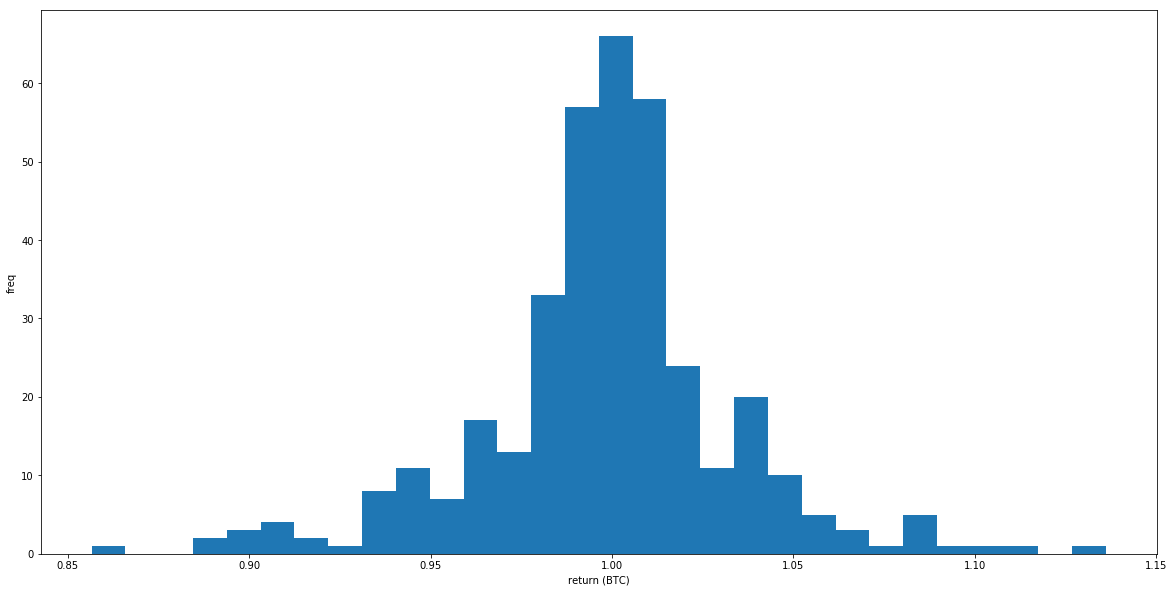

In [156]:
plt.figure(figsize=(20,10))
plt.hist(df_returns["BTC"], bins=30)
plt.xlabel("return (BTC)")
plt.ylabel("freq")
plt.show()

We generally assume that these "raw" returns are log-normally distributed, and therefore its $\log$ will be better behaved under many statistical models, because it is normally distributed. We'll compute these and examine:

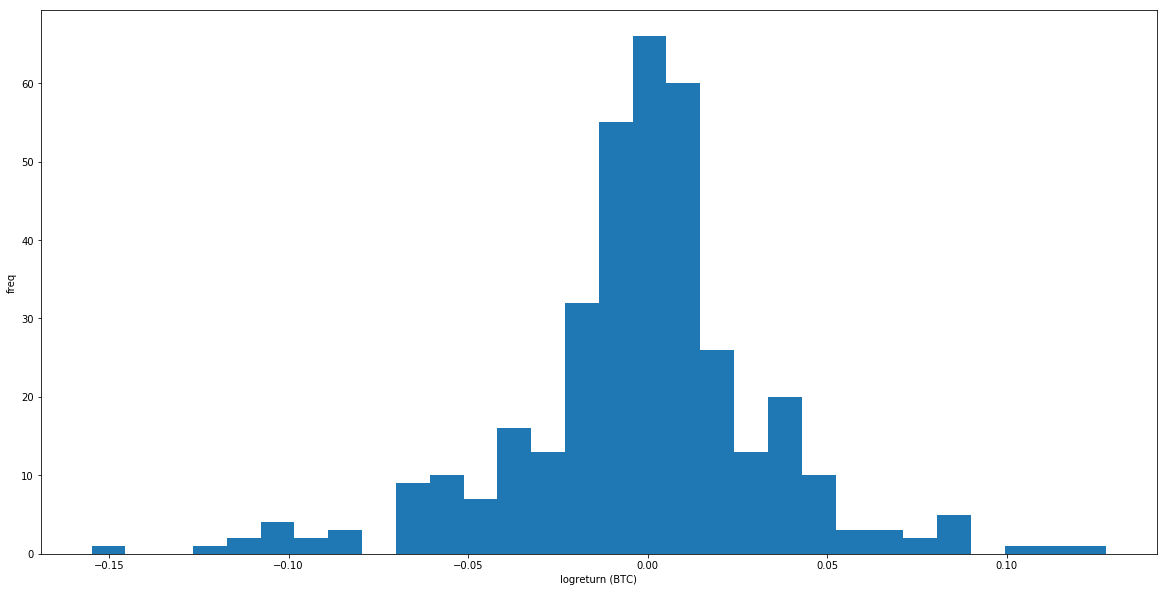

In [157]:
df_logreturns = np.log(df_returns)
plt.figure(figsize=(20,10))
plt.hist(df_logreturns["BTC"], bins=30)
plt.xlabel("log(return) (BTC)")
plt.ylabel("freq")
plt.show()

Which does indeed look slightly better (notice the thinner tails). We can also plot these returns over time (this time for both Bitcoin and Ethereum):

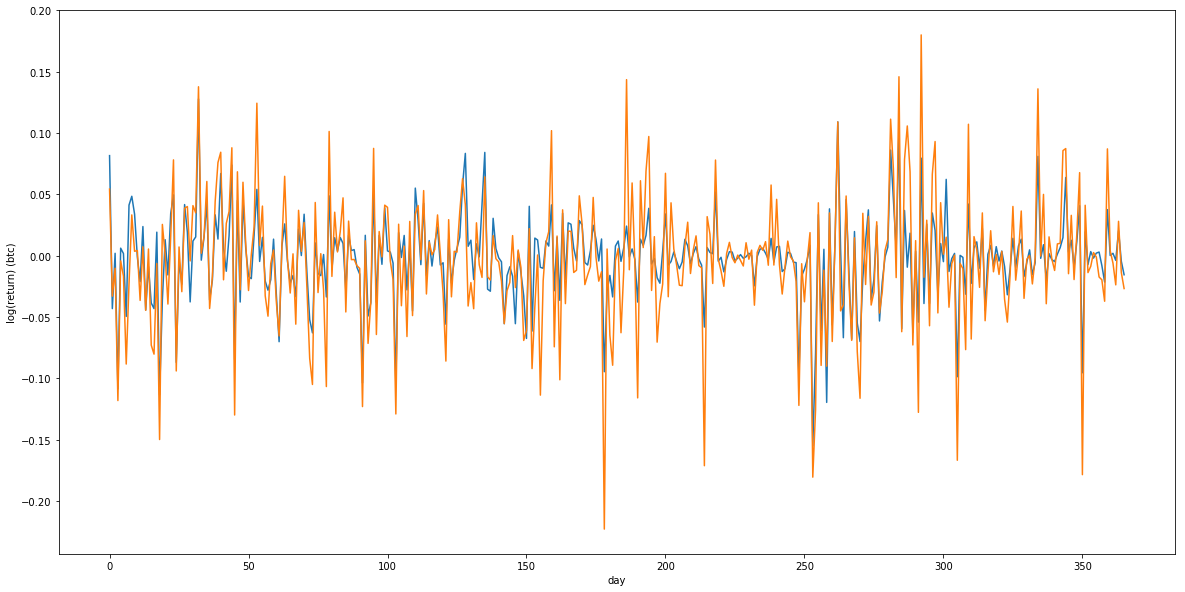

In [161]:
plt.figure(figsize=(20,10))
plt.plot(df_logreturns[["BTC", "ETH"]])
plt.xlabel("day")
plt.ylabel("log(return) (btc)")
plt.show()

One of the modern problems in econometrics is portfolio choice - that is, how can we choose an optimal portfolio of assets to maximize our returns over time. I think it would be interesting to see if we can apply this to cryptocurrencies (which are known to be particularly volatile). It poses unique modeling challenges, and the goal will be to address them.

# Goal

Our goal is to build a predictive model for portfolio choice. Formally:

Let $\mathbf{r}(t) \in \mathbb{R}^n$ be the return of each of $n$ assets at time $t$, where $r_i(t) = \log{\frac{x_i(t + 1)}{x_i(t)}}$ for $i = 1, \dots, n$. Define the asset covariance matrix as in the econometrics literature as $\Sigma(t) = \mathbf{r}(t) \mathbf{r}(t)^T \in \mathbb{R}^{n \times n}$. Let our training data be $\{ \mathbf{r}(t) | t \in 1, \dots, T \}$ where $T$ is the number of training timepoints. Our goal is to define a model capable of then predicting $r(T + 1)$ and $\Sigma(T + 1)$. We can then optimize portfolio choice by maximizing the Sharpe ratio:

$$\frac{\mathbf{w}^T \mathbf{r}(T + 1)}{\sqrt{\mathbf{w}^T \Sigma(T + 1) \mathbf{w}}}$$

where $\mathbf{w} \in \mathbb{S}^{n - 1}$, i.e. $\mathbf{w}$ is a unit vector.

Note that we're being deliberately vague about how we're going to compute $\mathbf{r}(T + 1)$ and $\Sigma(T + 1)$ - we'll try a number of different predictive models with the same sort of general idea.

# Choosing a model

There are several possible methods to estimate $\mathbf{r}(T + 1)$:

* Simple regression
* Autoregressive models
* Neural networks (RNNs in particular)
* Bayesian methods

There are also methods (apparently generally lesser-known outside of econometrics) to estimate $\Sigma(T + 1)$, including autoregressive models like MGARCH, but these frequently make problematic assumptions.

A common technique is to model the returns with a model like ARIMA, and the volatility with a model like MGARCH, combining them for forecasting.

I think an interesting idea would be to use ARIMA to predict future returns $\mathbf{r}(t)$, and an alternative to MGARCH (the [generalized Wishart process](https://www.cs.cmu.edu/~andrewgw/gwp.pdf)) to model $\Sigma(t)$. Together, these will produce estimates of $\mathbf{r}(T + 1)$ and $\Sigma(T + 1)$ which can then be used for portfolio choice. The GWP has shown some advantages in highly correlated asset markets, as shown in the original paper, over MGARCH.

(I'm assuming some familiarity with Gaussian processes - [here](https://www.cs.toronto.edu/~hinton/csc2515/notes/gp_slides_fall08.pdf) is a good introduction, and the seminal book is [R&W](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) - chapters 1, 2, 4, and 5 are useful references).

## Generalized Wishart process

The key idea of the generalized Wishart process is summarized in equation (12) of the original paper. Essentially, if $\mathbf{u_i} \sim \mathcal{N}(\mathbf{0}, I)$ for $i = 1, \dots, \nu$, and $L$ is the lower Cholesky decomposition of a symmetric psd matrix, then $\Sigma = \sum_i L\mathbf{u_i}\mathbf{u_i}^TL^T \sim \mathcal{W}(LL^T, \nu)$. Here, $\mathcal{W}$ is the Wishart distribution, which can be thought of as a distribution over covariance matrices. In our case, $\mathbf{u_i} \in \mathbb{R}^N$, where $N$ is the number of assets we're modeling, and thus $\Sigma$ is a covariance matrix over the assets of interest. If we make the $\mathbf{u_i}$s smoothly dependent on time, then our covariance matrix is _also_ smoothly dependent on time. One easy way to do this is to model the $\mathbf{u_i}$s as zero-mean Gaussian processes, defined entirely by their kernel function (see [here](https://www.cs.toronto.edu/~duvenaud/cookbook/) for a great, short reference). Then, our covariance matrix is completely defined by this kernel function as well.

Below, we define some common kernel functions used in GPs:

In [162]:
def ou(t1, t2, params):
    """
    Ornstein-Uhlenbeck kernel. Commonly used for financial data because
    it's not quite as smooth as the squared-exponential kernel.
    """
    tau = params[0]
    
    return np.exp(-abs(t2 - t1)/tau)

def squared_exponential(t1, t2, params):
    """
    Squared-exponential kernel. This is generally considered the "gold
    standard" in the GP literature because it is universal - within some
    assumptions, it can approximate any continuous function.
    """
    tau = params[0]
    
    return np.exp(-0.5*((t1 - t2)/tau)**2)

def periodic(t1, t2, params):
    """
    A simple periodic kernel function.
    """
    tau = params[0]
    
    return np.exp(-2*np.sin((t1 - t2)/2)**2/tau**2)

There are infinitely many possible kernels, and we can increase the space even more by noticing that sums of kernels are also valid kernels.

We'll now implement the model for $\Sigma(t)$. It's a direct implementation of equations (15)-(17) and the sampling procedure described in the GWP paper. We follow their direction and implement [elliptical slice sampling](http://proceedings.mlr.press/v9/murray10a/murray10a.pdf) for sampling the GPs which construct $\Sigma(t)$. We use the `emcee` library in Python for the Metropolis-Hasting steps (learning $L$ and $\mathbf{\theta}$). The main flow of the program is in `gibbs_sampler`. I opted not to wrap these methods in a class for now because it made Jupyter development easier. Later on they'll be moved into separate classes so that they can be run outside this notebook.

In [ ]:
SIG_VAR = 0.95
KERNEL = squared_exponential
LOGTHETA_PRIOR_MEAN = 0.5
LOGTHETA_PRIOR_VAR = 2
L_PRIOR_VAR = 1
MH_THETA_SCALE = 1
MH_L_SCALE = 1e-1
KERNEL_SCALE = 1

def kidx(Nu, N, T):
    return lambda a, b, c: a * (N * T) + b * T + c

def construct_kernel(params, T, k):
    """
    Construct a GP kernel.
    
    params: The kernel parameters of dimension ν x N x h where ν is the
            d.f., N is the dimensionality of the data, and h is the number
            of parameters for the kernel function.
    T:      The number of timepoints.
    k:      The kernel function.
    
        Returns a νNT x νNT kernel matrix.
    """
    Nu, N, h = params.shape
    kernel_idx = kidx(Nu, N, T)
    
    K = np.eye(np.prod([Nu, N, T]))
    for nu in range(Nu):
        for n in range(N):
            for t1 in range(T):
                for t2 in range(T):
                    i = kernel_idx(nu, n, t1)
                    j = kernel_idx(nu, n, t2)
                    if t1 != t2:
                        K[i, j] = k(t1, t2, params[nu, n, :])
    
    return K * KERNEL_SCALE

def compute_sigma(L, u):
    """
    Compute the covariance matrix for a specific timepoint.
    
    L: The lower cholesky decomposition of the scale parameter for the Wishart
       distribution (of dimension N x N).
    u: The fitted GP function values that generate the draw from the Wishart distribution.
       Dimensionality: ν x N.
       
    Returns the N x N covariance matrix.
    """
    Nu = u.shape[0]
    Sig = np.zeros(L.shape)
    for nu in range(Nu):
        Sig += np.matmul(L, np.matmul(np.outer(u[nu, :], u[nu, :]), L.T))
    
    return Sig

def log_data_likelihood(returns, u, L, Nu):
    """
    The likelihood of the data. We sum over all possible timepoints
    $t \in [T]$, computing the probability using r(t) ~ N(0, Σ(t)).
    """
    loglik = 0
    N, T = returns.shape
    u = np.reshape(u, (Nu, N, T))
    for t in range(T):
        Siginv = np.linalg.inv(compute_sigma(L, u[:, :, t]))
        term = -0.5*np.matmul(returns[:, t].T, np.matmul(Siginv, returns[:, t]))
        loglik += term
    
    return loglik

def init_logtheta(nu, N, h=1):
    """
    Initialize the GP hyperparameters to their logs.
    
    Returns a ν x N x h matrix where each is an independent draw from
    the LogNormal prior.
    """
    return np.random.normal(size=(nu, N, h))

def init_u(T, theta):
    """
    Initialize the GP draws that will construct the covariance matrix.
    
    T:     The number of timepoints.
    theta: The kernel parameters, of dimension ν x N x h where ν is the
           d.f., N is the dimensionality of the data, and h is the number
           of parameters for the kernel function.
    
    Returns a matrix of dimension ν x N x T which is a random draw from
    the multivariate normal with kernel constructed by theta.
    """
    N, nu, _ = theta.shape
    K = construct_kernel(theta, T, KERNEL)
    draw = np.random.multivariate_normal(np.zeros(K.shape[0]), K)
    
    return draw

def init_L(N):
    """
    Initialize the scale parameter for the Wishart distribution.
    
    Randomly generates a symmetric matrix V, then returns its lower
    Cholesky decomposition.
    """
    # X = np.random.randn(N, N)
    # V = np.matmul(X, X.T)
    # L = np.linalg.cholesky(V)
    L = np.eye(N)
    
    return L * L_PRIOR_VAR

def sample_u(f, theta, T, L, nu, returns):
    """
    Sample u (equation 15). We use
    [elliptical slice sampling](https://arxiv.org/abs/1001.0175),
    specifically a direct implementation of the algorithm in figure 2.
    """
    K = construct_kernel(theta, T, KERNEL)
    Kinv = np.linalg.inv(K)
    
    ellipse = np.random.multivariate_normal(np.zeros(K.shape[0]), K)
    u = np.random.uniform()
    logy = log_data_likelihood(returns, f, L, nu) + np.log(u)
    angle = np.random.uniform(high=2*np.pi)
    angle_min, angle_max = angle - 2*np.pi, angle
    while True:
        fp = f*np.cos(angle) + ellipse*np.sin(angle)
        log_data_lik = log_data_likelihood(returns, fp, L, nu)
        if log_data_lik > logy:
            log_u_lik = -0.5*np.matmul(fp, np.matmul(Kinv, fp))
            return fp, log_data_lik + log_u_lik
        else:
            if angle < 0:
                angle_min = angle
            else:
                angle_max = angle
            angle = np.random.uniform(angle_min, angle_max)

def sample_logtheta(logtheta, u, T, L, nu, returns):
    """
    Sample theta (equation 16). We use standard M-H as implemented in
    emcee to directly sample the next position in the chain.
    """
    def log_logtheta_prob(logthp):
        """
        Computes log(P(u | theta) * P(theta)) directly.
        """
        logthp = np.reshape(logthp, theta.shape)
        K = construct_kernel(np.exp(logthp), T, KERNEL)
        Kinv = np.linalg.inv(K)
        log_u_prob = -0.5*np.matmul(u, np.matmul(Kinv, u))
        log_prior = np.sum(
            -0.5*((logthp - LOGTHETA_PRIOR_MEAN)**2/LOGTHETA_PRIOR_VAR)
        )
        
        return log_u_prob + log_prior
        
    dim = np.prod(logtheta.shape)
    sampler = emcee.MHSampler(np.eye(dim)*MH_THETA_SCALE, dim=dim, lnprobfn=log_logtheta_prob)
    logthetap, _, _ = sampler.run_mcmc(logtheta.flatten(), 1)
    
    return np.reshape(logthetap, logtheta.shape), log_logtheta_prob(logthetap)

def sample_L(L, theta, u, nu, returns):
    """
    Sample L (equation 17). We again use standard M-H as implemented in
    emcee.
    """
    def log_L_prob(Lp):
        """
        Computes log(P(returns | u, L) * P(L)).
        """
        Lpm = np.zeros(L.shape)
        Lpm[np.tril_indices(L.shape[0])] = Lp
        log_prior = np.sum(-0.5*Lp**2/L_PRIOR_VAR)
        
        return log_data_likelihood(returns, u, Lpm, nu) + log_prior
    
    dim = int((L.shape[0]**2 + L.shape[0])/2)
    sampler = emcee.MHSampler(np.eye(dim)*MH_L_SCALE, dim=dim, lnprobfn=log_L_prob)
    Lp, _, _ = sampler.run_mcmc(L[np.tril_indices(L.shape[0])], 1)
    Lpm = np.zeros(L.shape)
    Lpm[np.tril_indices(L.shape[0])] = Lp
    
    return Lpm, log_L_prob(Lp)

def gibbs_sampler(returns, init=None, numit=1000):
    """
    Perform Gibbs sampling in order to fit the model.
    
    returns: A matrix of dimension N x T where N is the number of assets
             and T is the number of timepoints. Element (n, t) is the
             return of the nth asset at time t.
    
    Returns the chain of samples and diagnostics.
    """
    samples = []
    diagnostics = []
    
    # Set the hyperparameters
    N, T = returns.shape
    nu = N + 1
    
    # Initialize the model parameters
    if init:
        logtheta = init['logtheta']
        u = init['u']
        L = init['L']
    else:
        logtheta = init_logtheta(nu, N)
        u = init_u(T, np.exp(logtheta))
        logtheta = init_logtheta(nu, N)
        L = init_L(N)
    
    samples.append([u, np.exp(logtheta), L])

    # Sample successively. This will converge to draws from
    # P(u, theta, L | returns).
    for it in range(numit):
        data_lik = log_data_likelihood(returns, u, L, nu)
        u, u_prob = sample_u(u, np.exp(logtheta), T, L, nu, returns)
        logtheta, logtheta_prob = sample_logtheta(logtheta, u, T, L, nu, returns)
        L, L_prob = sample_L(L, np.exp(logtheta), u, nu, returns)
        if it % 10 is 0:
            print(
                "Iteration {}: loglik = {:.2f}, log P(u|...) = {:.2f}, log P(theta|...) = {:.2f}, log P(L|...) = {:.2f}".format(
                    it, data_lik, u_prob, logtheta_prob, L_prob
                )
            )
        
        samples.append([u, np.exp(logtheta), L])
        diagnostics.append([data_lik, u_prob, logtheta_prob, L_prob])
        
    return samples, diagnostics

We run the model like this:

In [ ]:
samples, diagnostics = gibbs_sampler(data_std, numit=500)

We can assess model convergence by looking at the data likelihood $P(\mathcal{D} | L, u, \theta)$. It's better, however, to look at the posterior over each parameter (e.g. $\log P(u | \dots)$). We plot both below:

In [ ]:
diagnostics = np.asarray(diagnostics)

plt.figure(figsize=(12, 10))
for pn in range(4):
    plt.subplot(2, 2, pn + 1)
    plt.plot(diagnostics[:, pn])
    plt.xlabel("iteration")
    plt.ylabel("log prob")

plt.show()

We can see that the model converges fairly well - depending on initialization, it only requires between 100 and 1,000 "burn-in" iterations (or so). In theory we can select any sample after that point and it's a valid sample from the posterior $P(u, L, \theta | \mathcal{D})$ where $\mathcal{D}$ is the training data.

We can predict according to equation (22) of the GWP paper, and compute $\Sigma(T + 1)$:

In [ ]:
def predict(L, u, theta, Nu, N, T):
    Kbinv = np.linalg.inv(construct_kernel(theta, T, KERNEL))
    Kfull = construct_kernel(theta, T + 1, KERNEL)
    idx = Nu * N * T
    A = Kfull[idx:, :idx]
    ustar = np.reshape(np.matmul(np.matmul(A, Kbinv), u), (Nu, N, 1))
    
    return compute_sigma(L, ustar[:, :, 0])

In [ ]:
print(diagnostics[np.argmax(diagnostics[:, 0]), :])
top_sample = samples[np.argmax(diagnostics[:, 0])]
u, theta, L = top_sample
V = np.matmul(L, L.T)
print(predict(L, u, theta, 7, 6, 50))

### Returns model

We'll now implement a simple algorithm using `emcee` to fit individual GPs to each cryptocurrency's returns. We'll assume each asset's returns are modeled by a zero-mean Gaussian process with an Ornstein-Uhlenbeck kernel. The parameters of the model are the timescales ($\tau$). We'll assume each asset has its own timescale and signal variance, so we can fit a model for each asset individually.

In [47]:
normalizer = np.diag(1/np.sqrt(np.diag(np.cov(data))))
normalizer_inv = np.linalg.inv(normalizer)
data_std = np.matmul(normalizer, data)

array([[1.        , 0.6218257 , 0.34368838, 0.55990029, 0.61117633,
        0.55801741],
       [0.6218257 , 1.        , 0.47430934, 0.81847755, 0.8335165 ,
        0.74821961],
       [0.34368838, 0.47430934, 1.        , 0.48087326, 0.58455575,
        0.39200074],
       [0.55990029, 0.81847755, 0.48087326, 1.        , 0.77532598,
        0.68567335],
       [0.61117633, 0.8335165 , 0.58455575, 0.77532598, 1.        ,
        0.68520224],
       [0.55801741, 0.74821961, 0.39200074, 0.68567335, 0.68520224,
        1.        ]])

In [ ]:
GP_KERNEL = periodic
NWALKERS = 100
TAU_PRIOR_MEAN = 0.75
TAU_PRIOR_VAR = 1
SIG_VAR_ALPHA = 10
SIG_VAR_BETA = 1.1

def construct_kernel_gp(tau, sig_var, T, k):
    K = np.eye(T)
    for t1 in range(T):
        for t2 in range(t1, T):
            if t1 != t2:
                c = sig_var * k(t1, t2, [tau])
                K[t1, t2] = c
                K[t2, t1] = c
    
    return K

def fit_gp(returns, numit=1_000):
    def log_likelihood(params):
        tau, sig_var = params
        if tau > 0 and sig_var < 1 and sig_var > 0:
            K = construct_kernel_gp(tau, sig_var, len(returns), GP_KERNEL)
            Kinv = np.linalg.inv(K)
            loglik = -0.5*np.matmul(returns, np.matmul(Kinv, returns))
            logtauprior = np.log(1/tau) - 0.5*(np.log(tau) - TAU_PRIOR_MEAN)**2/TAU_PRIOR_VAR
            logsigprior = np.log(sig_var**(SIG_VAR_ALPHA - 1)) + np.log((1 - sig_var)**(SIG_VAR_BETA - 1))
            
            return loglik + logtauprior + logsigprior
        else:
            return -np.inf
    
    init = [[np.random.lognormal(0, 1), np.random.uniform(0.87, 0.97)] for _ in range(NWALKERS)]
    
    sampler = emcee.EnsembleSampler(NWALKERS, 2, log_likelihood)
    ret = sampler.run_mcmc(init, numit)
    
    return sampler, ret

As an example, let's fit a GP model on the Bitcoin returns, an examine the corner plots for the two parameters:

In [ ]:
sampler, ret = fit_gp(btc[:50], 500)
corner.corner(sampler.chain[:, 100:, :].reshape(-1, 2), labels=["$t$", "$s$"])

In [ ]:
optimal_params = ret[0][np.argmax(ret[1]), :]
optimal_params

Prediction from a GP is straightforward (conditional multivariate normal):

In [ ]:
def predict_gp(prev, k, k_params):
    tau, sig_var = k_params
    T = len(prev)
    K = construct_kernel_gp(tau, sig_var, T + 2, GP_KERNEL)
    
    return np.matmul(K[:T, T], np.matmul(np.linalg.inv(K[:T, :T]), prev))

In [ ]:
res = predict_gp(btc[:50], GP_KERNEL, optimal_params)
res, btc[50]

And we get an OK prediction (scale might be a bit off, but the direction looks OK).

## Portfolio choice

In order to fulfill our goal of a fully automatic portfolio choice algorithm, we need to fit an individual GP to each asset's returns in addition to modeling the covariance matrix. Now seems like a reasonable time to extract our work from this notebook into actual model classes and write some basic unit tests. We can test the new code here like so:

In [1]:
import numpy as np
import pandas as pd
import requests as req
import emcee
import matplotlib
from matplotlib import pyplot as plt
import corner
%matplotlib inline
data_std = np.loadtxt("data.txt")

In [2]:
from model.backtest import backtest_gp, backtest_gwp, backtest_gp_window, backtest_gwp_window
from model.kernels import squared_exponential, periodic, ou, generate_sum_kernel, generate_prod_kernel
from model.gp import GaussianProcess as GP

Fitting a GP to a single asset is straightforward:

In [46]:
numit, nwalkers = 500, 500

gp_per = GP(periodic, nwalkers, 0, 1, 10, 1.1, num_taus=2)
per_chain = gp_per.fit(price_std[0, :10], numit=numit)
print("Periodic: {:.2f}".format(gp_per.likelihood(gp_per.optimal_params())))

gp_se = GP(squared_exponential, nwalkers, 0, 1, 10, 1.1)
se_chain = gp_se.fit(price_std[0, :10], numit=numit)
print("SE: {:.2f}".format(gp_se.likelihood(gp_se.optimal_params())))

gp_ou = GP(squared_exponential, nwalkers, 0, 1, 10, 1.1)
ou_chain = gp_ou.fit(price_std[0, :10], numit=numit)
print("OU: {:.2f}".format(gp_ou.likelihood(gp_ou.optimal_params())))

gp_prod = GP(generate_prod_kernel(periodic, squared_exponential, num_taus=(2, 1)),
             nwalkers, 0, 1, 10, 1.1, num_taus=3)
prod_chain = gp_prod.fit(price_std[0, :10], numit=numit)
print("Periodic * SE: {:.2f}".format(gp_prod.likelihood(gp_prod.optimal_params())))

gp_sum = GP(generate_sum_kernel(periodic, squared_exponential, num_taus=(2, 1)),
            nwalkers, 0, 1, 10, 1.1, num_taus=3)
sum_chain = gp_sum.fit(price_std[0, :10], numit=numit)
print("Periodic + SE: {:.2f}".format(gp_sum.likelihood(gp_sum.optimal_params())))

gp_prod_ou = GP(generate_prod_kernel(periodic, ou, num_taus=(2, 1)),
             nwalkers, 0, 1, 10, 1.1, num_taus=3)
prod_chain = gp_prod_ou.fit(price_std[0, :10], numit=numit)
print("Periodic * OU: {:.2f}".format(gp_prod_ou.likelihood(gp_prod_ou.optimal_params())))

gp_sum_ou = GP(generate_sum_kernel(periodic, ou, num_taus=(2, 1)),
            nwalkers, 0, 1, 10, 1.1, num_taus=3)
sum_chain = gp_sum_ou.fit(price_std[0, :10], numit=numit)
print("Periodic + OU: {:.2f}".format(gp_sum_ou.likelihood(gp_sum_ou.optimal_params())))

Periodic: -7.12
SE: -4.85
OU: -4.92
Periodic * SE: -6.23
Periodic + SE: -6.24
Periodic * OU: -6.34
Periodic + OU: -6.90


And we can look at the corner plot and the selected optimal parameters:

[0.43900065 0.89159499]


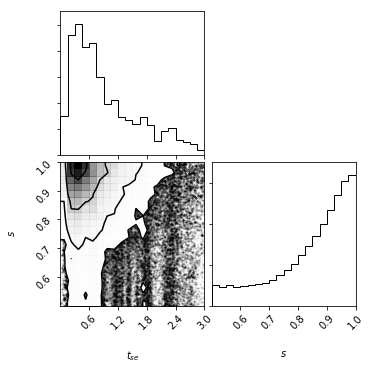

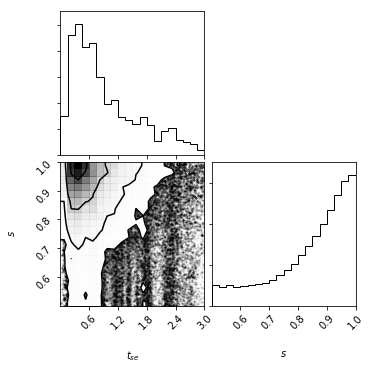

In [93]:
print(gp_ou.optimal_params())
corner.corner(sum_chain[:, 100:, :].reshape(-1, 2), labels=["$t_{se}$", "$s$"],
              range=[(0., 3.), (0.5, 1.0)])

In [112]:
gp_pred = backtest_gp_window(data_std[:, :15], 10, generate_sum_kernel(periodic, squared_exponential, num_taus=(2,1)),
                             num_taus=3, numit=numit, nwalkers=nwalkers)

Fitting models (T = 10)... 0 1 2 3 emcee: Exception while calling your likelihood function:
  params: [2.66003843 0.65685267 0.65278493 0.97779502]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/root/Projects/cryptoanalysis/model/gp.py", line 64, in likelihood
    Kinv = np.linalg.inv(K)
  File "/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
KeyboardInterrupt


KeyboardInterrupt: 

In [63]:
gwp_pred = backtest_gwp_window(data_std[:, :30], 10, squared_exponential, numit=5_000, progress=500)

Fitting initial model (T = 10)...
Fitting models for T = 10...


/root/Projects/cryptoanalysis/model/gwp.py:182: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  draw = np.random.multivariate_normal(np.zeros(K.shape[0]), K)
/root/Projects/cryptoanalysis/model/gwp.py:114: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  ellipse = np.random.multivariate_normal(np.zeros(K.shape[0]), K)


Iter 0: loglik = -6949.94, log P(u|...) = -5986.11, log P(tau|...) = -191.27, log P(L|...) = -5813.47
Iter 500: loglik = -9.79, log P(u|...) = -198.22, log P(tau|...) = -211.78, log P(L|...) = -36.70
Iter 1000: loglik = -10.31, log P(u|...) = -202.52, log P(tau|...) = -214.98, log P(L|...) = -30.67
Iter 1500: loglik = -10.45, log P(u|...) = -206.51, log P(tau|...) = -222.97, log P(L|...) = -30.85
Iter 2000: loglik = -10.51, log P(u|...) = -206.68, log P(tau|...) = -224.27, log P(L|...) = -28.17
Iter 2500: loglik = -8.66, log P(u|...) = -167.88, log P(tau|...) = -187.21, log P(L|...) = -31.14
Iter 3000: loglik = -12.86, log P(u|...) = -200.88, log P(tau|...) = -221.22, log P(L|...) = -34.02
Iter 3500: loglik = -11.20, log P(u|...) = -236.10, log P(tau|...) = -258.76, log P(L|...) = -22.36
Iter 4000: loglik = -8.78, log P(u|...) = -233.17, log P(tau|...) = -252.96, log P(L|...) = -23.84
Iter 4500: loglik = -9.04, log P(u|...) = -187.81, log P(tau|...) = -207.68, log P(L|...) = -32.69
Fit

Iter 0: loglik = -1386.44, log P(u|...) = -1588.11, log P(tau|...) = -218.65, log P(L|...) = -1385.68
Iter 500: loglik = -81.49, log P(u|...) = -341.06, log P(tau|...) = -293.41, log P(L|...) = -81.90
Iter 1000: loglik = -77.30, log P(u|...) = -344.69, log P(tau|...) = -300.55, log P(L|...) = -78.39
Iter 1500: loglik = -77.70, log P(u|...) = -323.40, log P(tau|...) = -277.96, log P(L|...) = -77.87
Iter 2000: loglik = -85.91, log P(u|...) = -328.27, log P(tau|...) = -288.76, log P(L|...) = -85.01
Iter 2500: loglik = -81.73, log P(u|...) = -315.40, log P(tau|...) = -270.12, log P(L|...) = -82.77
Iter 3000: loglik = -76.96, log P(u|...) = -305.04, log P(tau|...) = -265.99, log P(L|...) = -76.54
Iter 3500: loglik = -73.70, log P(u|...) = -311.38, log P(tau|...) = -274.96, log P(L|...) = -74.15
Iter 4000: loglik = -76.78, log P(u|...) = -325.84, log P(tau|...) = -284.04, log P(L|...) = -76.73
Iter 4500: loglik = -68.67, log P(u|...) = -322.34, log P(tau|...) = -296.03, log P(L|...) = -68.88

Fitting models for T = 26...
Iter 0: loglik = -1868.69, log P(u|...) = -2078.88, log P(tau|...) = -232.15, log P(L|...) = -1865.26
Iter 500: loglik = -124.91, log P(u|...) = -372.05, log P(tau|...) = -272.38, log P(L|...) = -125.10
Iter 1000: loglik = -97.07, log P(u|...) = -350.60, log P(tau|...) = -278.68, log P(L|...) = -97.35
Iter 1500: loglik = -89.39, log P(u|...) = -338.53, log P(tau|...) = -289.00, log P(L|...) = -91.12
Iter 2000: loglik = -87.76, log P(u|...) = -316.60, log P(tau|...) = -270.43, log P(L|...) = -87.76
Iter 2500: loglik = -87.01, log P(u|...) = -313.65, log P(tau|...) = -268.95, log P(L|...) = -86.28
Iter 3000: loglik = -85.23, log P(u|...) = -340.83, log P(tau|...) = -296.88, log P(L|...) = -85.54
Iter 3500: loglik = -95.79, log P(u|...) = -320.94, log P(tau|...) = -265.90, log P(L|...) = -96.64
Iter 4000: loglik = -89.52, log P(u|...) = -348.13, log P(tau|...) = -299.93, log P(L|...) = -89.79
Iter 4500: loglik = -99.86, log P(u|...) = -341.68, log P(tau|...) =

We'll now implement the code to maximize the Sharpe ratio. This has a straightforward closed form:

$$\frac{\Sigma^{-1}\mathbf{r}}{\mathbf{1}^T \Sigma^{-1} \mathbf{r}}$$

In [75]:
def choose_portfolio(r, cov, inv_var):
    r  = np.matmul(inv_var, r)
    val, vec = np.linalg.eigh(cov)
    # Cheap trick to regularize the matrix into good behaviour due to
    # numerical inaccuracies
    try:
        siginv = np.linalg.inv(cov)
    except:
        val = val - np.min(val) + 1e-8
        cov = np.matmul(vec.T, np.matmul(np.diag(val), vec))
        siginv = np.linalg.inv(cov)
    w = np.matmul(siginv, r) / np.matmul(np.full(len(r), 1), np.matmul(siginv, r))
    
    return w

We can compute the hypothetical return on a portfolio selected based on this computation for all of the predicted days:

In [79]:
def compute_return(r_pred, sig_pred, data):
    total = 1
    for day in range(len(r_pred)):
        w = choose_portfolio(r_pred[day], sig_pred[day], normalizer_inv)
        hypothetical_return = np.dot(w, np.exp(data[:, day]))
        total *= hypothetical_return
        print("Day {}: return = {}, running return = {}".format(
            day, hypothetical_return, total
        ))
    
    return total

Giving an overall return of:

In [110]:
compute_return(gp_pred[:5], gwp_pred[:5], data[:, 10:])

Day 0: return = 0.9905311027502376, running return = 0.9905311027502376
Day 1: return = 0.8819776400571144, running return = 0.8736262844068257
Day 2: return = 0.9761531062683052, running return = 0.8527930112413608
Day 3: return = 0.9560417620382957, running return = 0.8153057331211346
Day 4: return = 1.004994814134262, running return = 0.8193780337206729


0.8193780337206729

which doesn't look too bad. How would it compare to just re-investing returns day over day in BTC? Or in an equally distributed basket?

In [82]:
print(np.prod(np.exp(data[0, 10:15])))
print(np.prod(np.sum(np.exp(data[:, 10:15]), axis=0)/data.shape[0]))

1.0355998441367928
1.0249890495509109


## Conclusions

We built a reasonable model of portfolio choice for cryptocurrency returns. Given more time, there is still much to do:

* Compare to a model like MGARCH (easy to do in R)
* Improve the speed of the code
  - Kernel functions can be implemented in C, or make use of a library like `george`
  - Block-diagonal matrix inverses can be sped up in the case of the GWP
  - Message-passing implementation to model fitting may be possible
* Custom `corner` plots to investigate the relationship between the $\tau$ parameters and $L$
* Live plotting of model fitting
* Smarter initialization procedures to speed up convergence

We made some rather poor assumptions throughout the code as well. For example:

* We don't run the model for enough iterations - we basically rely on getting "lucky" initializations and MCMC chains.
* We assume the empirical mode (for GWP) and mean (for GPs) is in fact the best estimate of each parameter. However, when running it for low number of iterations as we are, the empirical mode might in fact be a better point estimate than the empirical mean, depending on the parameter - this should be investigated.

Finally, there is actually a better form of this model that allows joint estimation of the GPs and the GWP. It's called a [Gaussian process regression network](https://arxiv.org/pdf/1110.4411.pdf). There is an Infer.NET implementation, but it is outdated (8 years old) and it's non-trivial to get it running with the current version of Infer.NET. An implementation in Python is definitely possible: one can fit it using MCMC or VB. The model looks something like this:

$$\mathbf{r}(t) = W(t)[\mathbf{f}(t) + \sigma_f \mathbf{\epsilon}] + \sigma_r \mathbf{z}$$

Here, $W(t)$ is a matrix of GPs such that $W_{ij}(t) \sim \mathcal{GP}(0, k_w(t, t'))$ and $f(t)$ is a vector of GPs such that $f(t) \sim \mathcal{GP}(0, k_f(t, t'))$. Note that we maintain many of the same benefits of the GWP+GP model we implmented above: for example, possibly different kernels for $W$ and $f$. However, the joint estimation of $W(t)$ (which, when coupled with the $\epsilon$ noise model is analogous to the GWP in our model) and $f(t)$ (which is analogous to the GP in our model) will almost certainly produce superior results on any prediction task. This is for a number of reasons, but first and foremost: in the current model we don't factor in the variance of our predictions in our volatility model. For example, if we are more confident in our prediction of the return of one asset over another, shouldn't this affect our covariance matrix $\Sigma$? As of right now, it doesn't.